In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [15]:
INPUT_FILE = 'twitter-airline-sentiment/Tweets.csv'
VERSION = 'v3'

MODEL_PATH = 'models/%s/' % VERSION

import os
os.makedirs(MODEL_PATH, exist_ok=True)

In [4]:
from nltk.tokenize.casual import TweetTokenizer

REGEX_URL = re.compile(r'https?://|www.')
TOKEN_URL = 'xxurl'
TOKEN_HANDLE = 'xxhan'

def normalize_token(token):
    if token.startswith('@'):
        return TOKEN_HANDLE
    elif token.startswith('#') and token[1:].isalpha():
        return token[1:]
    elif re.match(REGEX_URL, token):
        return TOKEN_URL
    else:
        return token    

tokenizer = TweetTokenizer(preserve_case=True)

def normalize_text(text):
    tokens = tokenizer.tokenize(text)
    
    # if the first token is a handler, it's normally irrelevant
    if tokens[0].startswith('@'):
        tokens.pop(0)
    
    return ' '.join(normalize_token(t) for t in tokens)

In [5]:
raw_data = pd.read_csv(INPUT_FILE, header=0)

df = raw_data.copy()[['text', 'airline_sentiment']]
df = df.rename(columns={'airline_sentiment': 'sentiment'})
df_raw = df.copy()

df['text'] = df['text'].apply(normalize_text)
df_labeled = df[df.sentiment != 'neutral']

print("DATA SIZE: " + str(df.shape))
df.head()

DATA SIZE: (14640, 2)


,text,sentiment
0,What xxhan said .,neutral
1,plus you've added commercials to the experienc...,positive
2,I didn't today ... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious "" en...",negative
4,and it's a really big bad thing about it,negative


In [6]:
def show_normalization(_df):
    for i, row in _df.iterrows():
        print(row.sentiment.upper() + ": " + row.text + '\n>> ' + normalize_text(row.text) + '\n')

show_normalization(df_raw.head(30))

NEUTRAL: @VirginAmerica What @dhepburn said.
>> What xxhan said .

POSITIVE: @VirginAmerica plus you've added commercials to the experience... tacky.
>> plus you've added commercials to the experience ... tacky .

NEUTRAL: @VirginAmerica I didn't today... Must mean I need to take another trip!
>> I didn't today ... Must mean I need to take another trip !

NEGATIVE: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
>> it's really aggressive to blast obnoxious " entertainment " in your guests ' faces & they have little recourse

NEGATIVE: @VirginAmerica and it's a really big bad thing about it
>> and it's a really big bad thing about it

NEGATIVE: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
>> seriously would pay $ 30 a flight for seats that didn't have this playing . it's really the only bad thing about flying VA

POSITI

In [22]:
# creating the data source
bs = 48

data_lm = (TextList.from_df(df, cols=['text'], path=MODEL_PATH)
           .split_by_rand_pct(valid_pct=0.1, seed=0)
           .label_for_lm()
           .databunch(bs=bs))

In [23]:
data_lm.show_batch()

idx,text
0,"$ 30 a flight for seats that did n't have this playing . it 's really the only bad thing about flying xxup va xxbos yes , nearly every time i fly xxup vx this “ xxunk xxunk ” won ’ t go away :) xxbos xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk , there . xxurl xxbos xxmaj well , i did"
1,"xxbos to jump into the xxmaj dallas xxmaj austin market xxurl xxbos i spoke with a representative that offered no solution , i am a loyal customer who flies on xxhan as well xxbos i am xxunk disappointed that your birthday promo was not applied to a trip i booked xxunk days before i received the email xxbos what happened to direct flights from xxup sfo - xxup fll ?"
2,of communication :( xxbos checking to see why flight xxunk ( atl - ord ) got xxmaj cancelled xxmaj flighted ? xxbos service so far has been horrid . xxmaj we wanted to end the trip on a high note . xxmaj guess that 's not an option . xxbos xxmaj booked a flight home over 7 months ago and requested seats together for my xxunk and i . xxmaj
3,xxbos will not have to honor xxunk low mistake fares . xxurl xxunk xxhan xxbos xxunk delayed departure to check bags at gate claiming space filled and walk on to open xxunk a delay poorcustomerservice xxbos you xxmaj cancelled xxmaj flighted our flights for no reason & now we have been on the phone for xxup an xxup hour on our vacation . xxmaj why ? xxbos xxhan xxup that
4,"flight my flight . i wait in line to get rebooked , when i 'm at the front you make me go to another gate and i lose my place . xxbos it was n't a comment . xxmaj it was a question . xxmaj but thanks for your copy and paste response xxbos you failed me last week at xxup iah . xxmaj next intl trip on xxmaj delta"


In [24]:
data_lm.save('data_lm.pkl')

In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, path=MODEL_PATH)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 4.37E-02


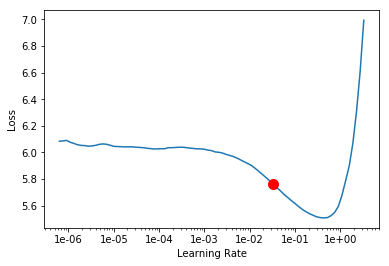

In [19]:
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.342616,3.989161,0.250833,00:12


In [27]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 3e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "My flight was"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:
learn.save_encoder('fine_tuned_enc')

### Classifier

In [ ]:
def balance_class_counts(df):
    class_counts = df.groupby('sentiment').count()
    min_size = class_counts['text'].min()
    classes = []
    for label in class_counts.index:
        classes.append(df.copy()[df.sentiment == label][:min_size])
    return pd.concat(classes, ignore_index=True).reset_index(drop=True)

In [ ]:
class_counts = df_labeled.groupby('sentiment').count()
class_counts

In [ ]:
data_clas = (TextList.from_df(df_labeled, cols=['text'], vocab=data_lm.vocab)
           .split_by_rand_pct(valid_pct=0.1, seed=0)
           .label_from_df(cols='sentiment')
           .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas.show_batch()

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(1, 7e-3, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3.5e-3/(2.6**4),3.5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1.75e-3/(2.6**4),1.75e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(3.5e-4/(2.6**4),3.5e-4), moms=(0.8,0.7))

In [ ]:
learn.predict("Awful flight")

In [ ]:
learn.predict("Great trip, thanks to all")

In [ ]:
learn.predict("attendant was rude!")

In [ ]:
learn.predict("I thought I was going to have some great vacations, but everything was ruined by the delay and the rude service. Way, to go @VirginAmerica!")

In [ ]:
learn.predict("My first time with you guys, pretty fair. Food was memorable :-)")